In [50]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [51]:
data_hor=pd.read_csv("Data/combined_data_ver.csv")
data_hor = data_hor.drop('Unnamed: 0', axis=1)
data_hor.head()

,Power_100_disc,Power_100_cont,Power_200_disc,Power_200_cont,Power_300_disc,Power_300_cont,Power_400_disc,Power_400_cont,Power_500_disc,Power_500_cont,Power_600_disc,Power_600_cont,Power_700_disc,Power_700_cont,Power_800_disc,Power_800_cont,Power_900_disc,Power_900_cont,Power_1000_disc,Power_1000_cont
0,1.902,0.000,3.321,0.99,1.61,3.912,0.012,6.596,0.504,1.176,0.086,3.753000,0.162,2.975,0.60,0.912000,0.233000,2.360,3.915000,7.248000
1,1.902,0.000,3.321,0.99,1.61,3.912,0.012,6.596,0.504,1.176,0.086,3.753000,0.162,2.975,0.60,0.912000,0.233000,2.360,3.915000,7.248000
2,2.364,2.272,6.030,0.99,2.34,2.934,0.012,3.104,0.504,1.176,1.470,8.757001,0.998,2.975,0.60,34.655998,0.676000,6.372,4.455000,7.248000
3,2.364,2.272,6.030,0.90,2.34,2.934,0.186,3.104,1.728,6.664,1.470,8.757001,0.998,9.350,3.56,34.655998,0.676000,6.372,4.455000,36.239998
4,5.122,2.272,12.730,0.90,2.34,2.934,0.186,3.104,1.728,6.664,20.580,8.757001,11.976,9.350,3.56,34.655998,22.307999,6.372,14.849999,36.239998


In [52]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_hor.columns]
scaler = MinMaxScaler()

perc=0.95

train_size = int(len(data_hor) * perc)
test_size = len(data_hor) - train_size
df_train = data_hor[0:train_size]
df_test = data_hor[train_size:len(data_hor)]

# scaled_train = scaler.fit_transform(df_train[power_list])
# scaled_test = scaler.transform(df_test[power_list])

scaled_train_and_test = scaler.fit_transform(data_hor[power_list])
scaled_train = scaled_train_and_test[0:train_size]
scaled_test = scaled_train_and_test[train_size:len(data_hor)]

In [53]:
print(len(scaled_train))
print(len(scaled_test))

23750
1250


In [54]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [55]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [56]:
# LOOK_BACK=int(len(scaled_test)/2)
LOOK_BACK=200
FORECAST_RANGE=20

## making the look_back according to the main frequency since the data are kindly periodic

n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23531, 200, 20)
(23531, 20, 20)
(1031, 200, 20)
(1031, 20, 20)


In [57]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [58]:
epochs = 50
batch_size = 32
validation = 0.1

In [59]:
# checkpoint_filepath = 'improvementsModel_combinedData_ver_20_mac_CNN_LSTM/weights-improvement-{epoch:06d}-{val_loss:.6f}.hdf5'

checkpoint_filepath = 'test/weights-improvement-{epoch:06d}-{val_loss:.6f}.hdf5'


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.005)

In [60]:
## CNN-LSTM Encoder - Decoder Model

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='tanh'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation='tanh', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='tanh')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

plot_model(model=model_enc_dec_cnn, show_shapes=True)
history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec_cnn.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/50
662/662 [==============================] - 116s 173ms/step - loss: 0.0198 - val_loss: 0.0223 - lr: 0.0010
Epoch 2/50
662/662 [==============================] - 113s 170ms/step - loss: 0.0080 - val_loss: 0.0234 - lr: 0.0010
Epoch 3/50
662/662 [==============================] - 115s 173ms/step - loss: 0.0062 - val_loss: 0.0219 - lr: 0.0010
Epoch 4/50
662/662 [==============================] - 112s 169ms/step - loss: 0.0055 - val_loss: 0.0229 - lr: 0.0010
Epoch 5/50
662/662 [==============================] - ETA: 0s - loss: 0.0052

In [ ]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='tanh')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

Text(0, 0.5, 'MAPE')

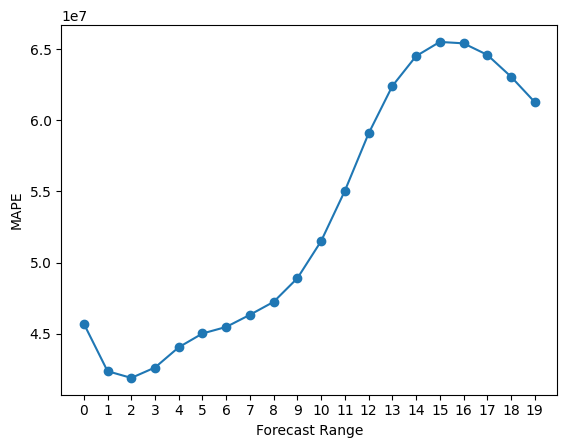

In [ ]:
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
    time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mape = mape_(y_test_time_step[i], yhat_time_step[i])
    mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE')

Text(0, 0.5, 'MAE')

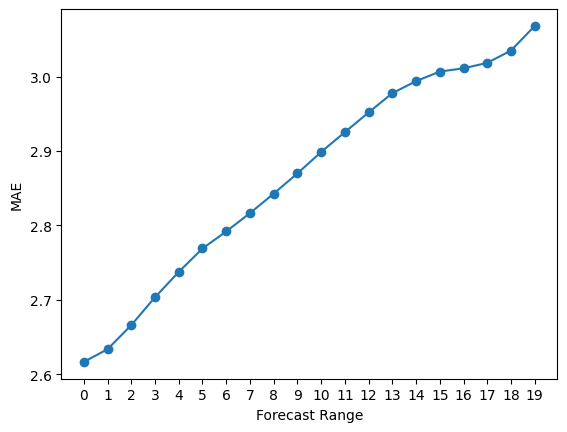

In [ ]:
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
    time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mae_list = []
for i in range(0, FORECAST_RANGE):
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mae = mae_(y_test_time_step[i], yhat_time_step[i])
    mae_list.append(mae)
plt.plot(range(0, FORECAST_RANGE), mae_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAE')

In [ ]:
for i in range(0, n_features):
    print('->', i)
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mae:', mae)
    mse = mse_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mse:', mse)
    mape = mape_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mape:', mape)

-> 0
mae: tf.Tensor(2.548317, shape=(), dtype=float32)
mse: tf.Tensor(12.436173, shape=(), dtype=float32)
mape: tf.Tensor(33.861916, shape=(), dtype=float32)
-> 1
mae: tf.Tensor(1.7308172, shape=(), dtype=float32)
mse: tf.Tensor(4.664468, shape=(), dtype=float32)
mape: tf.Tensor(250.36967, shape=(), dtype=float32)
-> 2
mae: tf.Tensor(2.4627678, shape=(), dtype=float32)
mse: tf.Tensor(10.932601, shape=(), dtype=float32)
mape: tf.Tensor(217.55698, shape=(), dtype=float32)
-> 3
mae: tf.Tensor(1.231868, shape=(), dtype=float32)
mse: tf.Tensor(2.623582, shape=(), dtype=float32)
mape: tf.Tensor(26.510418, shape=(), dtype=float32)
-> 4
mae: tf.Tensor(3.4585989, shape=(), dtype=float32)
mse: tf.Tensor(20.902023, shape=(), dtype=float32)
mape: tf.Tensor(149528080.0, shape=(), dtype=float32)
-> 5
mae: tf.Tensor(1.8373282, shape=(), dtype=float32)
mse: tf.Tensor(5.900963, shape=(), dtype=float32)
mape: tf.Tensor(61.971134, shape=(), dtype=float32)
-> 6
mae: tf.Tensor(3.0534635, shape=(), dtype=fl

19/19 [==============================] - 2s 106ms/step


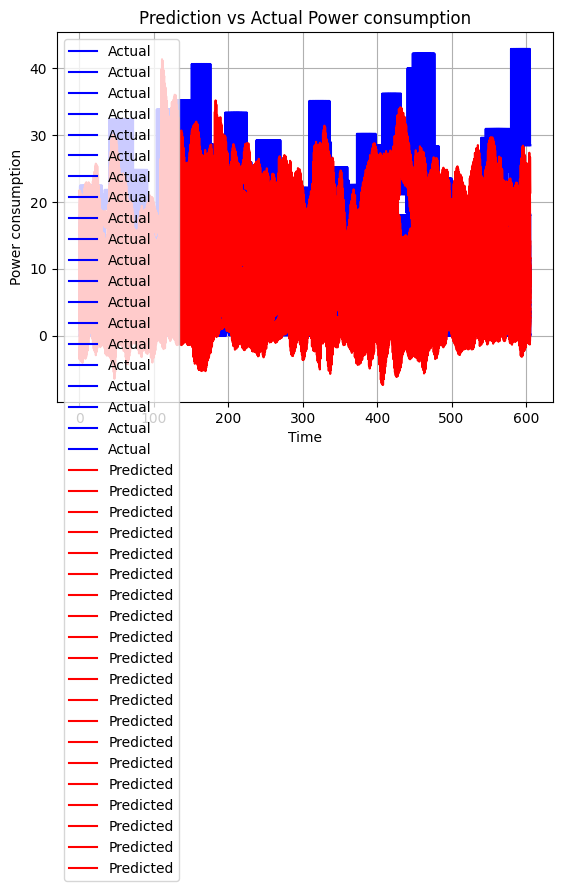

In [ ]:
## PREDICTION OVER ACTUAL VALUE


# # predict the test set
# y_test_pred = model_enc_dec_cnn.predict(X_test)

# # reshape the predictions and test set
# y_test_pred = y_test_pred.reshape(-1, y_test_pred.shape[-1])
# y_test = y_test.reshape(-1, y_test.shape[-1])

# #inverse the scaling
# y_test_pred = scaler.inverse_transform(y_test_pred)
# y_test = scaler.inverse_transform(y_test)

# # plot the predicted vs actual values
# plt.plot(y_test, label='Actual')
# plt.plot(y_test_pred, label='Predicted')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Power consumption')
# plt.title('Prediction vs Actual Power consumption')
# plt.show()

# predict the test set
y_test_pred = model_enc_dec_cnn.predict(X_test)

# reshape the predictions and test set
y_test_pred = y_test_pred.reshape(-1, y_test_pred.shape[-1])
y_test = y_test.reshape(-1, y_test.shape[-1])

#inverse the scaling
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

# create a time array
time = np.arange(y_test.shape[0])*0.05

# plot the predicted vs actual values
plt.plot(time, y_test, label='Actual', color='blue')
plt.plot(time, y_test_pred, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.title('Prediction vs Actual Power consumption')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()




In [ ]:
y_test

array([[ 5.4119997 ,  5.34000015,  3.02999997, ..., 12.44999981,
        16.89500046, 15.77999878],
       [ 5.4119997 ,  5.34000015,  3.02999997, ..., 12.44999981,
        14.01200104, 15.77999878],
       [ 5.4119997 ,  5.34000015,  3.02999997, ..., 12.44999981,
        14.01200104, 15.77999878],
       ...,
       [ 3.44999981,  0.26100001,  3.61899996, ...,  8.02499962,
        28.44000053,  7.296     ],
       [ 3.44999981,  0.26100001,  3.61899996, ...,  8.02499962,
        28.44000053,  7.296     ],
       [ 3.44999981,  0.26100001,  3.61899996, ...,  8.02499962,
        28.44000053,  7.296     ]])

In [ ]:
y_test_pred

array([[ 5.690864 ,  4.5898824,  1.0739405, ..., 20.802258 , 17.55953  ,
        16.120783 ],
       [ 5.2571435,  5.073482 ,  1.7489991, ..., 21.729563 , 18.072193 ,
        15.283102 ],
       [ 4.9807186,  5.2410865,  2.3589592, ..., 21.479551 , 17.404312 ,
        15.754608 ],
       ...,
       [ 3.9292297,  1.9883685,  2.5353677, ...,  6.1052194, 22.605772 ,
         7.605901 ],
       [ 3.977155 ,  2.0521898,  2.562303 , ...,  5.7892823, 21.943007 ,
         6.7456594],
       [ 4.0115366,  2.0898933,  2.5741544, ...,  5.551509 , 21.385513 ,
         6.1309414]], dtype=float32)

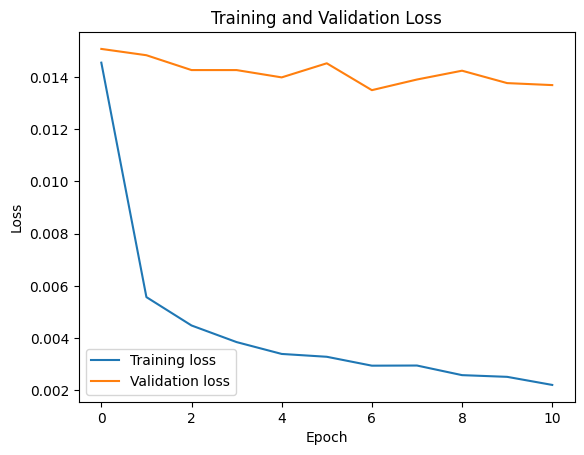

In [ ]:
# Training and validation loss over time

# # define the model and train it
# model = Sequential()
# # ... add layers to the model ...
# model.compile(loss='mean_squared_error', optimizer='adam')

# # define callbacks for Early stopping, reduce learning rate on plateau and save best model
# callbacks = [EarlyStopping(monitor='val_loss', patience=10),
#              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# # train the model and pass the validation data
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

# # plot the training and validation loss
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.show()

# define the model and train it
# model = Sequential()
# # ... add layers to the model ...
# model.compile(loss='mean_squared_error', optimizer='adam')

# # train the model and pass the validation data
# history = model_enc_dec_cnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

# # plot the training and validation loss
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.show()

# plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

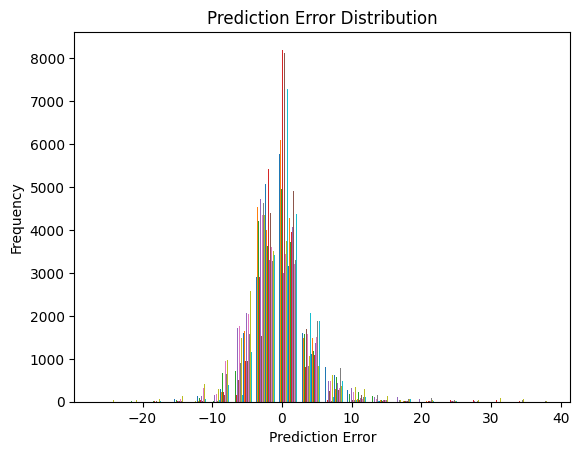

In [ ]:
# Prediction over distribution

# calculate the prediction error
error = y_test - y_test_pred

# plot the error distribution
plt.hist(error, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()


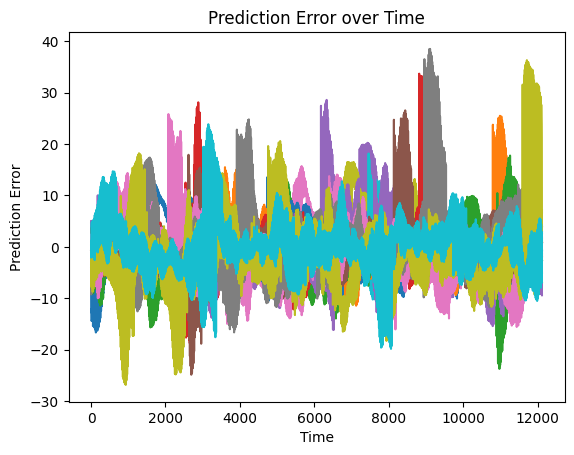

In [ ]:
# Prediction error over time:

# create a time array
time = np.arange(y_test.shape[0])

# calculate the prediction error
error = y_test - y_test_pred

# plot the error over time
plt.plot(time, error)
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.title('Prediction Error over Time')
plt.show()


IndexError: index 20 is out of bounds for axis 1 with size 20

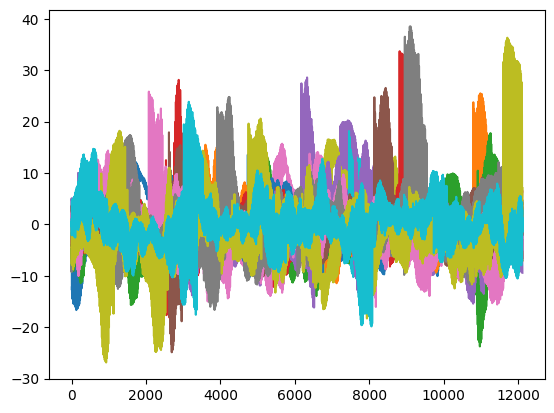

In [ ]:
# Prediction error over input feature:


# loop through each feature
for i in range(X_test.shape[1]):
    # calculate the error for the feature
    feature_error = y_test[:,i] - y_test_pred[:,i]
    # plot the error for the feature
    plt.plot(time, feature_error, label='Feature '+str(i))

plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.title('Prediction Error over Input Feature')
plt.legend()
plt.show()
